Project 1 Test Notebook

In [1]:
import sys
import math
import random
import numpy as np
import pandas as pd
import networkx as nx
from itertools import product
from scipy.special import gammaln

In [3]:
d = pd.read_csv('data/small.csv')
parents = ['age', 'fare', 'portembarked']
parent_inst_list = list(product(*[d[parent].unique() for parent in parents]))
for parent_inst in parent_inst_list:
    #select out the data consistent with the current set of parent values
    subset = d
    for l, p in enumerate(parents):
        subset = subset[subset[p] == parent_inst[l]]
    print(subset.to_string())

     age  portembarked  fare  numparentschildren  passengerclass  sex  numsiblings  survived
0      1             1     1                   1               1    1            1         1
2      1             1     1                   1               1    2            1         2
7      1             1     1                   1               1    1            2         1
10     1             1     1                   1               1    2            1         2
12     1             1     1                   1               1    1            1         1
14     1             1     1                   1               1    2            1         1
24     1             1     1                   1               1    2            2         1
37     1             1     1                   1               1    1            1         1
38     1             1     1                   1               1    2            1         1
49     1             1     1                   1               1    2 

In [58]:
d.columns[0]

'age'

In [57]:
dg = nx.DiGraph()
dg.add_nodes_from(d.columns)
dg.nodes

NodeView(('age', 'portembarked', 'fare', 'numparentschildren', 'passengerclass', 'sex', 'numsiblings', 'survived'))

In [90]:

#Compute bayesian score at the given node
def node_bayesian_score(dag, xi, data, reg_factor=0):
    score = 0
    #Number of instantiations of xi
    ri = len(np.unique(data[xi])) 


    parents = list(dag.predecessors(xi))
    #regularization (penalty to score based on num parents)
    if not reg_factor: score -= reg_factor * (len(parents) - 1)

    #No parents gives a simple calculation that does not require summing zeros
    if not len(parents):
        #assuming uniform prior, all a_ijk = 1, so sum(a_ij0) over range(ri) = ri
        a_i10 = ri
        #The sum of the counts of each instantiation of xi is the number of samples
        m_i10 = len(data)
        m_i1k = data[xi].value_counts()
        score += gammaln(a_i10) - gammaln(a_i10 + m_i10) + sum(gammaln(1 + m_i1k))
        return score

    #Cartesian product of each parent's instantiations giving a list of all possible combos of parent instantiations
    parent_inst_list = product(*[data[parent].unique() for parent in parents])
    #Loop over all possible sets of parent values
    for parent_inst in parent_inst_list:
        #select out the data consistent with the current set of parent values
        parent_data = data
        for j in range(len(parents)):
            is_consistent = parent_data[parents[j]] == parent_inst[j]
            parent_data = parent_data[is_consistent]
        #Count the number of occurences of observations consistent with current parent vals
        m_ijk = parent_data[xi].value_counts()
        m_ij0 = len(parent_data)
        score += gammaln(ri) - gammaln(ri + m_ij0) + sum(gammaln(1 + m_ijk))



    return score


 
def total_bayesian_score(dag, data):
    """Compute the total Bayesian score of the DAG by summing local scores for all nodes."""
    return sum(node_bayesian_score(dag, xi, data) for xi in list(dag.nodes)) 


def K2_search(dag, data, max_parents=2, reg_const= 0, max_iter = 1000, tol=10e-3):
    x = list(dag.nodes)
    scores = {xi : node_bayesian_score(dag, xi, data, reg_const) for xi in x}
    bScore = sum(scores.values())

    delta = 1.0 + tol # to ensure for loop starts
    counter = 0
    foundBetterGraph = True
    cur_dag = dag.copy()

    while foundBetterGraph and delta >= tol and counter <= max_iter:
        foundBetterGraph = False

        for child in x:
            cur_score = scores[child]
            new_score = cur_score
            best_parent = None

            if len(list(cur_dag.predecessors(child))) >= max_parents: continue

            for parent in x:
                if not dag.has_edge(parent, child) and parent != child:
                    dag_candidate = cur_dag.copy()
                    dag_candidate.add_edge(parent, child)
                    if not nx.is_directed_acyclic_graph(dag_candidate): continue

                    new_score = node_bayesian_score(dag_candidate, child, data, reg_const)
                    if new_score > cur_score: 
                        delta = new_score - cur_score
                        cur_score = new_score
                        best_parent = parent
            
            if best_parent != None:
                cur_dag.add_edge(best_parent, child)
                bScore += delta

            counter += 1

    return cur_dag

    
def local_directed_graph_search(dag, data, max_iter=100, max_parents=3):
    nodes = list(dag.nodes)
    n = len(dag)
    #scores = {node: local_bayesian_score(dag, node, data) for node in nodes}
    temp = 1.00
    cooling = 0.99


    cur_dag = dag.copy()
    for k in range(max_iter):
        i = random.randint(0, n - 1)
        j = (i + random.randint(1, n - 1)) % n
        vars = data.columns
        child = vars[j]
        parent = vars[i]
        y = node_bayesian_score(cur_dag, child, data)
        #y = bayesian_score(cur_dag, data)

        new_dag = cur_dag.copy()
        if cur_dag.has_edge(parent, child):
            new_dag.remove_edge(parent, child)
        elif len(list(new_dag.predecessors(child))) < max_parents:
            new_dag.add_edge(parent, child) 
        if not nx.is_directed_acyclic_graph(new_dag): continue
        y_new = node_bayesian_score(new_dag, child, data) 
        #y_new = bayesian_score(new_dag, data) 

        if y_new > y:
            cur_dag = new_dag

    return cur_dag


def compute(infile, gph_outfile, dot_outfile):
    data = pd.read_csv(infile)
    dag = nx.DiGraph()
    dag.add_nodes_from(data.columns)

    # learned_dag = local_directed_graph_search(dag, data)
    learned_dag = K2_search(dag, data)
    # Compute total score of learned DAG
    total_score = total_bayesian_score(learned_dag, data)
    print(f"Total Bayesian Score: {total_score}")

    # Write the learned structure to a file, using idx2names to map back to the column names
    write_gph(learned_dag, gph_outfile)

    write_dot_file(learned_dag, dot_outfile)


def write_gph(dag, filename):
    with open(filename, 'w') as f:
        for edge in dag.edges():
            f.write("{}, {}\n".format(edge[0], edge[1]))
            
def read_gph(infile):
    with open(infile, 'r') as file:
        return nx.read_edgelist(file, delimiter=',', create_using=nx.DiGraph(), nodetype=str)
    
def write_dot_file(dag, filename):
    with open(filename, 'w') as f:
        f.write("digraph G {\n")
        for edge in dag.edges():
            f.write(f'    "{edge[0]}" -> "{edge[1]}";\n')
        f.write("}\n")


In [92]:
compute('data/small.csv', 'small_test.gph', 'small_test.dot')

Total Bayesian Score: -3812.2096306215744


In [70]:
compute('data/medium.csv', 'medium_test.gph', 'medium_test.dot')

Total Bayesian Score: -102116.57973530809


In [278]:
with open('example/example.gph', 'r') as file:
    ex_g = nx.read_edgelist(file, delimiter=',', create_using=nx.DiGraph(), nodetype=str)

#ex_g = nx.read_edgelist('example_clean.txt', delimiter=',', create_using=nx.DiGraph(), nodetype=str, encoding='ascii')
ex_data = pd.read_csv('example/example.csv')
#names2idx = {name: i for i, name in enumerate(ex_data.columns)}
#ex_data = ex_data.rename(columns=names2idx)
total_bayesian_score(ex_g, ex_data)

-132.57689402451837

In [15]:
def write_gph(dag, idx2names, filename):
    with open(filename, 'w') as f:
        for edge in dag.edges():
            f.write("{}, {}\n".format(idx2names[edge[0]], idx2names[edge[1]]))

def local_bayesian_score(dag, node, data):
    """
    Compute the local Bayesian score for a node given its parents in the DAG and the data.
    The score is based on the Dirichlet-multinomial conjugate prior.
    """
    score = 0
    ri = max(data[node]) + 1  # assuming node values start from 0
    parents = list(dag.predecessors(node))

    # If there are no parents, the score simplifies to the marginal likelihood of the node
    if not parents:
        counts = data[node].value_counts()
        score += gammaln(ri) - gammaln(ri + len(data))
        for k in range(ri):
            score += gammaln(1 + counts.get(k, 0))
        return score

    # Otherwise, compute the full Bayesian score with parents
    parent_instantiations = product(*[data[p].unique() for p in parents])
    for inst in parent_instantiations:
        subset = data
        for l, p in enumerate(parents):
            subset = subset[subset[p] == inst[l]]
        counts = subset[node].value_counts()

        score += gammaln(ri) - gammaln(ri + len(subset))
        for k in range(ri):
            score += gammaln(1 + counts.get(k, 0))

    return score


def bayesian_score(dag, data):
    """Compute the total Bayesian score of the DAG by summing local scores for all nodes."""
    return sum(local_bayesian_score(dag, node, data) for node in dag.nodes)



simulated annealing

In [301]:
def read_gph(infile):
    with open(infile, 'r') as file:
        return nx.read_edgelist(file, delimiter=',', create_using=nx.DiGraph(), nodetype=str)
    
def local_directed_graph_search(dag, data, max_iter=100, max_parents=2):
    nodes = list(dag.nodes)
    n = len(dag)
    #scores = {node: local_bayesian_score(dag, node, data) for node in nodes}
    temp = 1.00
    cooling = 0.99


    cur_dag = dag.copy()
    for k in range(max_iter):
        i = random.randint(0, n - 1)
        j = (i + random.randint(1, n - 1)) % n
        y = node_bayesian_score(cur_dag, j, data)
        #y = bayesian_score(cur_dag, data)

        new_dag = cur_dag.copy()
        new_dag.remove_edge(i, j)  if cur_dag.has_edge(i, j) else new_dag.add_edge(i, j) 
        if not nx.is_directed_acyclic_graph(new_dag): continue
        y_new = node_bayesian_score(new_dag, j, data) 
        #y_new = bayesian_score(new_dag, data) 

        if y_new > y:
            cur_dag = new_dag

    return cur_dag

def compute(infile, outfile):
    """Main computation for Bayesian structure learning."""
    # Read the input CSV, with the first row as variable names
    data = pd.read_csv(infile)

    # Create mappings between indices and variable names
    idx2names = {i: name for i, name in enumerate(data.columns)}
    names2idx = {name: i for i, name in enumerate(data.columns)}

    # Create a directed graph with one node for each variable in the data, using indices
    dag = nx.DiGraph()
    dag.add_nodes_from(idx2names.keys())  # Add nodes using indices (0, 1, 2,...)

    # Map the data columns to their index positions
    data = data.rename(columns=names2idx)

    # Perform greedy search to learn the structure of the DAG
    learned_dag = local_directed_graph_search(dag, data)
    
    # Compute total score of learned DAG
    total_score = total_bayesian_score(learned_dag, data)
    print(f"Total Bayesian Score: {total_score}")

    # Write the learned structure to a file, using idx2names to map back to the column names
    write_gph(learned_dag, idx2names, outfile)

In [299]:
compute('data/small.csv', 'small_test.gph')

Total Bayesian Score: -3816.040484968363


In [300]:
compute('data/medium.csv', 'medium_test.gph')

Total Bayesian Score: -103338.20098929192


In [303]:
titanic_ex = read_gph('example/titanicexample.gph')
total_bayesian_score(titanic_ex, d)

-1962.473367606153

Search algorithm

In [78]:
def random_neighbor(dag):
    n = len(dag)
    i = random.randint(0, n - 1)
    j = (i + random.randint(1, n - 1)) % n
    new_dag = dag.copy()
    new_dag.remove_edge(i, j)  if dag.has_edge(i, j) else new_dag.add_edge(i, j) 
    return new_dag

def is_cyclic(dag):
    try:
        nx.find_cycle(dag)
        return True
    except nx.NetworkXNoCycle:
        return False
    
def local_directed_graph_search(dag, data, max_iter=1000, max_parents=2):
    nodes = list(dag.nodes)
    n = len(dag)
    scores = {node: local_bayesian_score(dag, node, data) for node in nodes}
    temp = 1.00
    cooling = 0.99


    cur_dag = dag.copy()
    y = -math.inf
    for k in range(max_iter):
        i = random.randint(0, n - 1)
        j = (i + random.randint(1, n - 1)) % n
        best_local_score = scores[j]
        new_dag = cur_dag.copy()
        new_dag.remove_edge(i, j)  if dag.has_edge(i, j) else new_dag.add_edge(i, j) 
        if not nx.is_directed_acyclic_graph(new_dag): continue

        new_local_score = local_bayesian_score(new_dag, j, data) 
        if new_local_score > best_local_score:
            cur_dag = new_dag
            scores[j] = new_local_score
    return cur_dag

def compute(infile, outfile):
    """Main computation for Bayesian structure learning."""
    # Read the input CSV, with the first row as variable names
    data = pd.read_csv(infile)

    # Create mappings between indices and variable names
    idx2names = {i: name for i, name in enumerate(data.columns)}
    names2idx = {name: i for i, name in enumerate(data.columns)}

    # Create a directed graph with one node for each variable in the data, using indices
    dag = nx.DiGraph()
    dag.add_nodes_from(idx2names.keys())  # Add nodes using indices (0, 1, 2,...)

    # Map the data columns to their index positions
    data = data.rename(columns=names2idx)

    # Perform greedy search to learn the structure of the DAG
    learned_dag = greedy_search(dag, data)
    
    # Compute total score of learned DAG
    total_score = bayesian_score(learned_dag, data)
    print(f"Total Bayesian Score: {total_score}")

    # Write the learned structure to a file, using idx2names to map back to the column names
    write_gph(learned_dag, idx2names, outfile)


In [ ]:
def K2_search(dag, data, max_parents = 2):
    

In [81]:
def greedy_search(dag, data, max_parents=3):
    """
    Perform a greedy search to maximize the Bayesian score of the DAG.
    We add edges iteratively as long as they improve the score and do not introduce cycles.
    """
    nodes = list(dag.nodes)
    scores = {node: local_bayesian_score(dag, node, data) for node in nodes}
    #total_score = sum(scores.values())

    improved = True
    while improved:
        improved = False
        for node in nodes:
            best_local_score = scores[node]
            best_parent = None

            for candidate_parent in nodes:
                if candidate_parent == node or dag.has_edge(candidate_parent, node):
                    continue

                dag_temp = dag.copy()
                dag_temp.add_edge(candidate_parent, node)

                # Ensure the graph remains a DAG
                if not nx.is_directed_acyclic_graph(dag_temp):
                    continue

                # Compute the new local Bayesian score
                new_local_score = local_bayesian_score(dag_temp, node, data)
                if new_local_score > best_local_score and len(list(dag_temp.predecessors(node))) <= max_parents:
                    best_local_score = new_local_score
                    best_parent = candidate_parent

            if best_parent:
                dag.add_edge(best_parent, node)
                #total_score += (best_local_score - scores[node])
                scores[node] = best_local_score
                improved = True

    return dag

In [82]:
compute('data/small.csv', 'small_test.gph')

Total Bayesian Score: -3938.6416550278213


In [70]:
compute('data/medium.csv', 'medium_test.gph')

KeyboardInterrupt: 

In [ ]:
    best_dag = dag
    max_score = -math.inf
    for restart in range(num_restarts):
        learned_dag = local_directed_graph_search(dag, data)
        total_score = bayesian_score(learned_dag, data)
        if total_score > max_score:
            max_score = total_score
            best_dag = learned_dag

In [61]:
compute('data/large.csv', 'large_test.gph')

Total Bayesian Score: -464603.5667822197


In [2]:


def bayesian_score(vars, G, D):
    # Placeholder function for Bayesian score calculation
    # Implement the actual scoring based on Bayesian Dirichlet score
    # For now, we'll return a random score
    return random.random()

def rand_graph_neighbor(G):
    n = G.number_of_nodes()
    i = random.randint(0, n-1)
    j = random.randint(0, n-1)
    G_new = G.copy()
    if G.has_edge(i, j):
        G_new.remove_edge(i, j)
    else:
        G_new.add_edge(i, j)
    return G_new

def is_cyclic(G):
    try:
        nx.find_cycle(G)
        return True
    except nx.NetworkXNoCycle:
        return False

def fit(G, vars, D, k_max):
    y = bayesian_score(vars, G, D)
    for _ in range(k_max):
        G_new = rand_graph_neighbor(G)
        if is_cyclic(G_new):
            y_new = float('-inf')
        else:
            y_new = bayesian_score(vars, G_new, D)
        if y_new > y:
            y, G = y_new, G_new
    return G

# Example usage
def main():
    # Initialize a directed graph
    G = nx.DiGraph()
    G.add_nodes_from(range(5))  # Add 5 nodes for example
    
    vars = list(G.nodes)
    D = None  # Placeholder for your data
    k_max = 1000  # Number of iterations
    
    optimized_graph = fit(G, vars, D, k_max)
    print(f"Optimized graph edges: {optimized_graph.edges()}")

if __name__ == "__main__":
    main()
def compute(infile, outfile):
    # WRITE YOUR CODE HERE
    # FEEL FREE TO CHANGE ANYTHING ANYWHERE IN THE CODE
    # THIS INCLUDES CHANGING THE FUNCTION NAMES, MAKING THE CODE MODULAR, BASICALLY ANYTHING
    pass

In [ ]:
#Algorithm 4.2 to generate uniform priors for each node
def prior(dag, data):
    n = data.shape[1]
    #list of num instantiations of X_i
    r = [max(data[i]) for i in range(n)]
    #list of num of instantiations of parents of X_i for each node X_i
    #if X_i has no parents, q_i = 1
    q = [np.prod([r[j] for j in list(dag.predecessors(i))]) if list(dag.predecessors(i)) else 1 for i in range(n)]
    #return the list of pseudocount matrices for each node
    return [np.ones((q[i], r[i])) for i in range(n)]

n = data.shape[1]
#list of num instantiations of X_i
r = [max(data[i]) for i in range(n)]
#list of num of instantiations of parents of X_i for each node X_i
#if X_i has no parents, q_i = 1
q = [np.prod([r[j] for j in list(dag.predecessors(i))]) for i in range(n)]
#return the list of pseudocount matrices for each node
priors = [np.ones((q[i], r[i])) for i in range(n)]
#count matrices
M = [np.zeros((q[i], r[i])) for i in range(n)]

In [ ]:
import random

class LocalDirectedGraphSearch:
    def __init__(self, G, k_max):
        self.G = G  # initial graph
        self.k_max = k_max  # number of iterations

    def rand_graph_neighbor(self):
        n = len(self.G)
        i = random.randint(0, n - 1)
        j = random.choice([x for x in range(n) if x != i])
        G_prime = [row[:] for row in self.G]  # deep copy of G
        if self.G[i][j] == 1:
            G_prime[i][j] = 0  # remove edge
        else:
            G_prime[i][j] = 1  # add edge
        return G_prime

    def bayesian_score(self, vars, G, D):
        # Placeholder for the actual Bayesian score calculation logic
        return random.random()   # random score for testing

    def is_cyclic(self, G):
        # Placeholder for cycle detection logic
        return False

    def fit(self, vars, D):
        y = self.bayesian_score(vars, self.G, D)
        for k in range(self.k_max):
            G_prime = self.rand_graph_neighbor()
            if not self.is_cyclic(G_prime):
                y_prime = self.bayesian_score(vars, G_prime, D)
                if y_prime > y:
                    self.G = G_prime
                    y = y_prime
        return self.G

# Example usage:
# initial_graph = [[0, 1], [0, 0]]  # Example adjacency matrix
# search = LocalDirectedGraphSearch(initial_graph, 100)
# optimized_graph = search.fit(vars, D)  # vars and D would need to be defined

C:\Users\kapil\AppData\Local\Temp\ipykernel_14216\4069771175.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


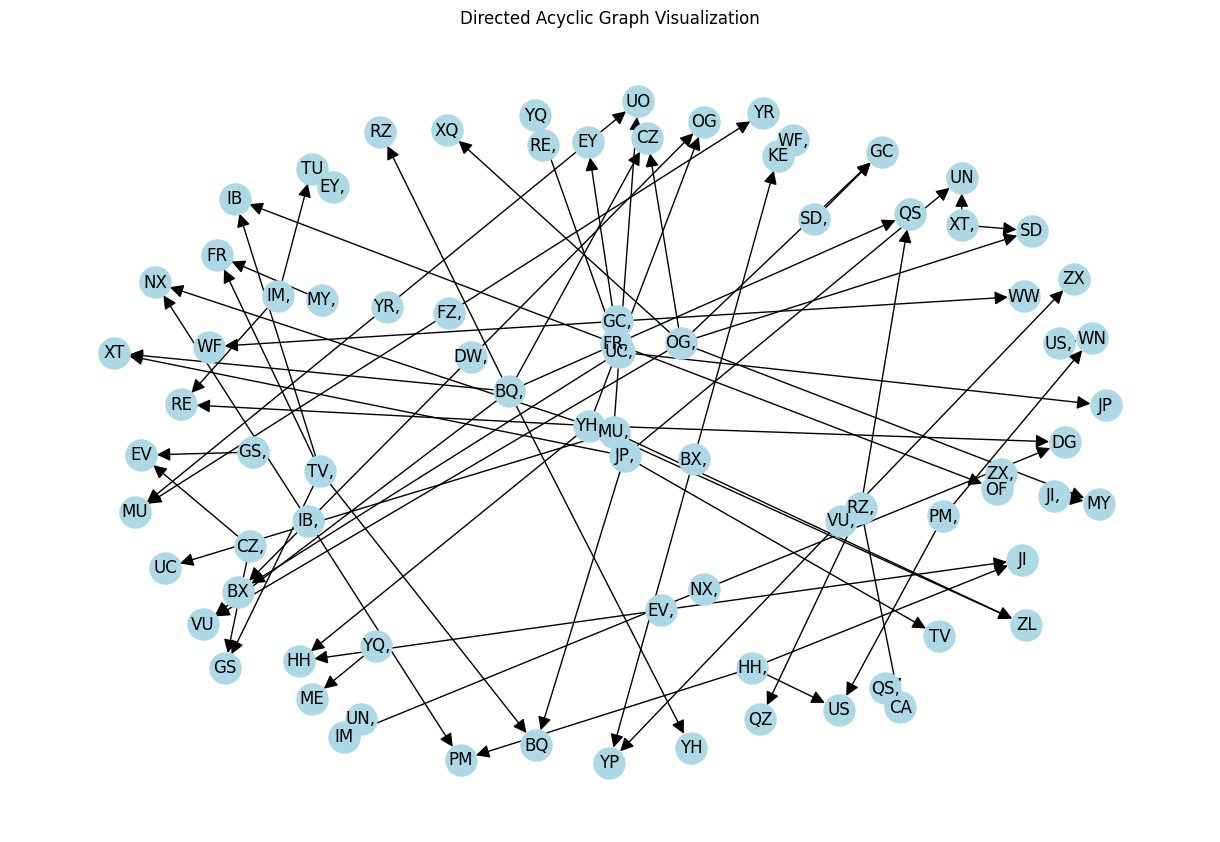

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

def read_gph_file(file_path):
    G = nx.DiGraph()  # Create a directed graph
    with open(file_path, 'r') as f:
        for line in f:
            # Assuming each line in the file represents an edge in the format 'source target'
            edge = line.strip().split()  # Split by whitespace
            if len(edge) == 2:
                G.add_edge(edge[0], edge[1])  # Add edge to the graph
    return G

def visualize_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)  # Position nodes using a spring layout
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, arrowsize=20, arrows=True)
    plt.title("Directed Acyclic Graph Visualization")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
file_path = os.path.join('..', '..', 'large_test1.gph')  # Replace with your actual file path
graph = read_gph_file(file_path)
visualize_graph(graph)